# 集成学习算法的非均匀方式
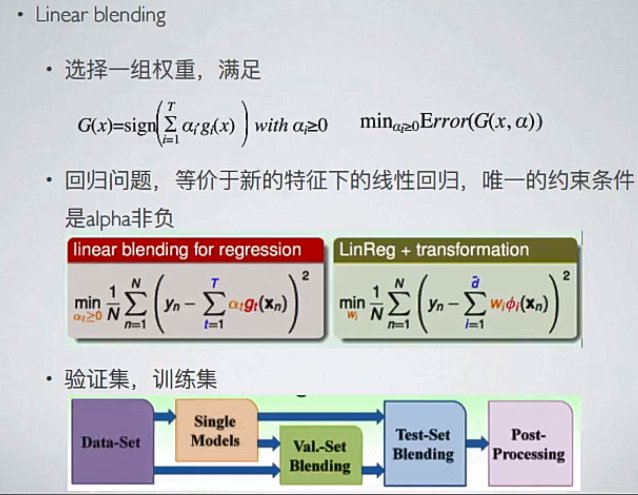

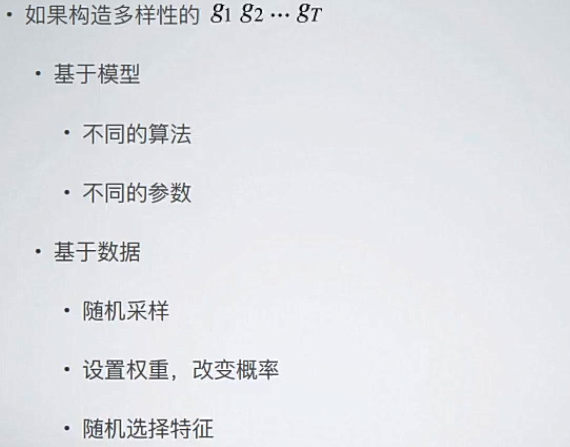

不同算法 ： svm，贝叶斯等等 g1.g2...gt

不同参数 惩罚系数等等

更重要的是基于数据的方法

采样：有放回

数据权重：adaboost的方法

特征：不可重复，如随机森林

基于权重更新
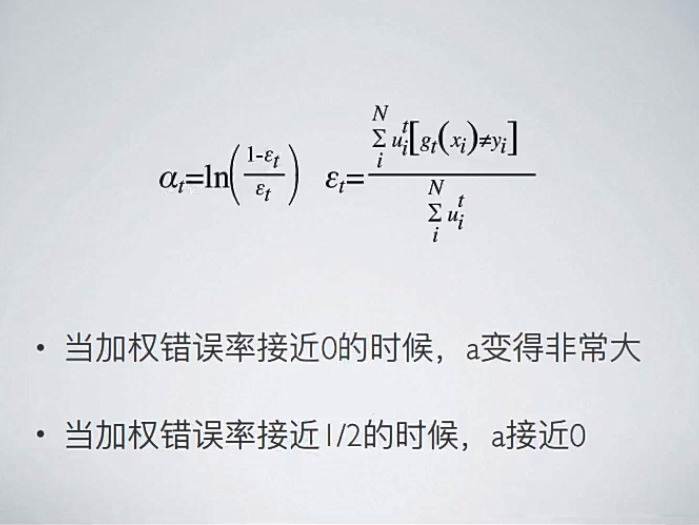

yita的推导看笔记本
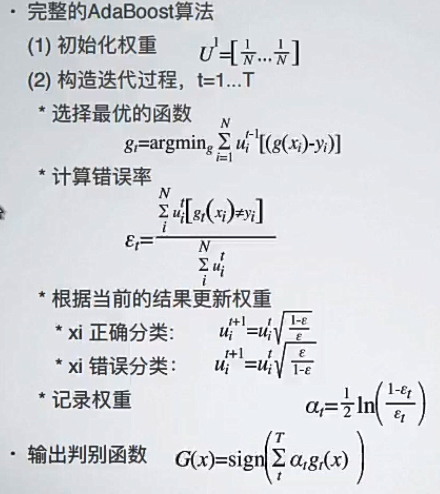

样本稀疏不适用。

In [4]:
from numpy import *

In [5]:
def loadSimpData():
    """ 测试数据
    Returns:
        dataArr   feature对应的数据集
        labelArr  feature对应的分类标签
    """
    dataArr = array([[1., 2.1], [2., 1.1], [1.3, 1.], [1., 1.], [2., 1.]])
    labelArr = [1.0, 1.0, -1.0, -1.0, 1.0]
    return dataArr, labelArr

In [6]:
def loadDataSet(fileName):
    # get number of fields
    numFeat = len(open(fileName).readline().split('\t'))
    dataArr = []
    labelArr = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataArr.append(lineArr)
        labelArr.append(float(curLine[-1]))
    return dataArr, labelArr

In [7]:
def stumpClassify(dataMat, dimen, threshVal, threshIneq):
    """stumpClassify(将数据集，按照feature列的value进行 二分法切分比较来赋值分类)

    Args:
        dataMat    Matrix数据集
        dimen      特征列
        threshVal  特征列要比较的值
    Returns:
        retArray 结果集
    """
    # 默认都是1
    retArray = ones((shape(dataMat)[0], 1))
    # dataMat[:, dimen] 表示数据集中第dimen列的所有值
    # threshIneq == 'lt'表示修改左边的值，gt表示修改右边的值
    # print '-----', threshIneq, dataMat[:, dimen], threshVal
    if threshIneq == 'lt':
        retArray[dataMat[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMat[:, dimen] > threshVal] = -1.0
    return retArray

In [8]:
def buildStump(dataArr, labelArr, D):
    """buildStump(得到决策树的模型)

    Args:
        dataArr   特征标签集合
        labelArr  分类标签集合
        D         最初的样本的所有特征权重集合
    Returns:
        bestStump    最优的分类器模型
        minError     错误率
        bestClasEst  训练后的结果集
    """
    # 转换数据
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).T
    # m行 n列
    m, n = shape(dataMat)

    # 初始化数据
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m, 1)))
    # 初始化的最小误差为无穷大
    minError = inf

    # 循环所有的feature列，将列切分成 若干份，每一段以最左边的点作为分类节点
    for i in range(n):
        rangeMin = dataMat[:, i].min()
        rangeMax = dataMat[:, i].max()
        # print 'rangeMin=%s, rangeMax=%s' % (rangeMin, rangeMax)
        # 计算每一份的元素个数
        stepSize = (rangeMax-rangeMin)/numSteps
        # 例如： 4=(10-1)/2   那么  1-4(-1次)   1(0次)  1+1*4(1次)   1+2*4(2次)
        # 所以： 循环 -1/0/1/2
        for j in range(-1, int(numSteps)+1):
            # go over less than and greater than
            for inequal in ['lt', 'gt']:
                # 如果是-1，那么得到rangeMin-stepSize; 如果是numSteps，那么得到rangeMax
                threshVal = (rangeMin + float(j) * stepSize)
                # 对单层决策树进行简单分类，得到预测的分类值
                predictedVals = stumpClassify(dataMat, i, threshVal, inequal)
                # print predictedVals
                errArr = mat(ones((m, 1)))
                # 正确为0，错误为1
                errArr[predictedVals == labelMat] = 0
                # 计算 平均每个特征的概率0.2*错误概率的总和为多少，就知道错误率多高
                # 例如： 一个都没错，那么错误率= 0.2*0=0 ， 5个都错，那么错误率= 0.2*5=1， 只错3个，那么错误率= 0.2*3=0.6
                weightedError = D.T*errArr
                '''
                dim            表示 feature列
                threshVal      表示树的分界值
                inequal        表示计算树左右颠倒的错误率的情况
                weightedError  表示整体结果的错误率
                bestClasEst    预测的最优结果
                '''
                # print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal

    # bestStump 表示分类器的结果，在第几个列上，用大于／小于比较，阈值是多少
    return bestStump, minError, bestClasEst

In [9]:
def adaBoostTrainDS(dataArr, labelArr, numIt=40):
    """adaBoostTrainDS(adaBoost训练过程放大)

    Args:
        dataArr   特征标签集合
        labelArr  分类标签集合
        numIt     实例数
    Returns:
        weakClassArr  弱分类器的集合
        aggClassEst   预测的分类结果值
    """
    weakClassArr = []
    m = shape(dataArr)[0]
    # 初始化 D，设置每行数据的样本的所有特征权重集合，平均分为m份
    D = mat(ones((m, 1))/m)
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        # 得到决策树的模型
        bestStump, error, classEst = buildStump(dataArr, labelArr, D)

        # alpha 目的主要是计算每一个分类器实例的权重(加和就是分类结果)
        # 计算每个分类器的 alpha 权重值
        alpha = float(0.5*log((1.0-error)/max(error, 1e-16)))
        bestStump['alpha'] = alpha
        # store Stump Params in Array
        weakClassArr.append(bestStump)

        # print "alpha=%s, classEst=%s, bestStump=%s, error=%s " % (alpha, classEst.T, bestStump, error)
        # 分类正确：乘积为1，不会影响结果，-1主要是下面求e的-alpha次方
        # 分类错误：乘积为 -1，结果会受影响，所以也乘以 -1
        expon = multiply(-1*alpha*mat(labelArr).T, classEst)
        # print '\n'
        # print 'labelArr=', labelArr
        # print 'classEst=', classEst.T
        # print '\n'
        # print '乘积: ', multiply(mat(labelArr).T, classEst).T
        # 判断正确的，就乘以-1，否则就乘以1， 为什么？ 书上的公式。
        # print '(-1取反)预测值expon=', expon.T
        # 计算e的expon次方，然后计算得到一个综合的概率的值
        # 结果发现： 判断错误的样本，D对于的样本权重值会变大。
        D = multiply(D, exp(expon))
        D = D/D.sum()
        # print "D: ", D.T
        # print '\n'

        # 预测的分类结果值，在上一轮结果的基础上，进行加和操作
        # print '当前的分类结果：', alpha*classEst.T
        aggClassEst += alpha*classEst
        # print "叠加后的分类结果aggClassEst: ", aggClassEst.T
        # sign 判断正为1， 0为0， 负为-1，通过最终加和的权重值，判断符号。
        # 结果为：错误的样本标签集合，因为是 !=,那么结果就是0 正, 1 负
        aggErrors = multiply(sign(aggClassEst) != mat(labelArr).T, ones((m, 1)))
        errorRate = aggErrors.sum()/m
        # print "total error=%s " % (errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

In [10]:
def adaClassify(datToClass, classifierArr):
    # do stuff similar to last aggClassEst in adaBoostTrainDS
    dataMat = mat(datToClass)
    m = shape(dataMat)[0]
    aggClassEst = mat(zeros((m, 1)))

    # 循环 多个分类器
    for i in range(len(classifierArr)):
        # 前提： 我们已经知道了最佳的分类器的实例
        # 通过分类器来核算每一次的分类结果，然后通过alpha*每一次的结果 得到最后的权重加和的值。
        classEst = stumpClassify(dataMat, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        # print aggClassEst
    return sign(aggClassEst)

In [11]:
def plotROC(predStrengths, classLabels):
    """plotROC(打印ROC曲线，并计算AUC的面积大小)

    Args:
        predStrengths  最终预测结果的权重值
        classLabels    原始数据的分类结果集
    """
    print 'predStrengths=', predStrengths
    print 'classLabels=', classLabels

    import matplotlib.pyplot as plt
    # variable to calculate AUC
    ySum = 0.0
    # 对正样本的进行求和
    numPosClas = sum(array(classLabels)==1.0)
    # 正样本的概率
    yStep = 1/float(numPosClas)
    # 负样本的概率
    xStep = 1/float(len(classLabels)-numPosClas)
    # argsort函数返回的是数组值从小到大的索引值
    # get sorted index, it's reverse
    sortedIndicies = predStrengths.argsort()
    # 测试结果是否是从小到大排列
    print 'sortedIndicies=', sortedIndicies, predStrengths[0, 176], predStrengths.min(), predStrengths[0, 293], predStrengths.max()

    # 开始创建模版对象
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # cursor光标值
    cur = (1.0, 1.0)
    # loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        # draw line from cur to (cur[0]-delX, cur[1]-delY)
        # 画点连线 (x1, x2, y1, y2)
        print cur[0], cur[0]-delX, cur[1], cur[1]-delY
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    # 画对角的虚线线
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    # 设置画图的范围区间 (x1, x2, y1, y2)
    ax.axis([0, 1, 0, 1])
    plt.show()
    '''
    参考说明：http://blog.csdn.net/wenyusuran/article/details/39056013
    为了计算 AUC ，我们需要对多个小矩形的面积进行累加。
    这些小矩形的宽度是xStep，因此可以先对所有矩形的高度进行累加，最后再乘以xStep得到其总面积。
    所有高度的和(ySum)随着x轴的每次移动而渐次增加。
    '''
    print "the Area Under the Curve is: ", ySum*xStep

[{'dim': 9, 'ineq': 'gt', 'thresh': 3.0, 'alpha': 0.4616623792657674}, {'dim': 17, 'ineq': 'gt', 'thresh': 52.5, 'alpha': 0.31248245042467104}, {'dim': 3, 'ineq': 'gt', 'thresh': 55.199999999999996, 'alpha': 0.2868097320169577}, {'dim': 18, 'ineq': 'lt', 'thresh': 62.300000000000004, 'alpha': 0.23297004638939506}, {'dim': 10, 'ineq': 'lt', 'thresh': 0.0, 'alpha': 0.19803846151213741}, {'dim': 5, 'ineq': 'gt', 'thresh': 2.0, 'alpha': 0.18847887349020634}, {'dim': 12, 'ineq': 'lt', 'thresh': 1.2, 'alpha': 0.15227368997476778}, {'dim': 7, 'ineq': 'gt', 'thresh': 1.2, 'alpha': 0.15510870821690512}, {'dim': 5, 'ineq': 'lt', 'thresh': 0.0, 'alpha': 0.13536197353359405}, {'dim': 4, 'ineq': 'lt', 'thresh': 28.799999999999997, 'alpha': 0.12521587326132078}, {'dim': 11, 'ineq': 'gt', 'thresh': 2.0, 'alpha': 0.1334764812820767}, {'dim': 9, 'ineq': 'lt', 'thresh': 4.0, 'alpha': 0.1418224325377107}, {'dim': 14, 'ineq': 'gt', 'thresh': 0.0, 'alpha': 0.10264268449708028}, {'dim': 0, 'ineq': 'lt', 'th

sortedIndicies= [[176  40  35 192 272  49 101  16  83 181 230  44 296 179 172 225  97 239
  170 141 227  59 244 150 168 256 295 285 121  45  46  86 173 291 246 210
   30  43  73 234  48 290 245 108  99 159 110 281 204 178  80 109   8 134
  219 280 113 133 128 252  58 200 253 229 123 262  15  64 292 249 171 140
  184  62 207 216 273 177 221  36   0  54  91 151 203   4  19 261  34 271
    3 297  70 143 294  10 104 135  78 209  57 162 270 147  72 195 117 247
   75 241 242  31  93 164 238  68 218  84 282  63  55 126  37 186  39 254
  286 232  26  25 258  18  20 196 263 237 174 287  28 278 114 274 167 251
  118  79  17 124 131  51 250  56  74 188 160  66 201 298 215 130  65  24
  266  41  13 205 190   1 154 226 206 268 106 265 127  87  42  82 269 193
  156  33  53   7 139 220 144  27  96 105 243 211 231 102 163 146 275 198
  180   9 217 189  90 185 138 259  14   6 212  32  11 284  81 187 111  88
  119  60 222 264 157 112 129 267 169 233  94 236  95 155 228 136 276 240
    2  22  50 255 120 

0.173553719008 0.173553719008 0.741573033708 0.73595505618
0.173553719008 0.165289256198 0.73595505618 0.73595505618
0.165289256198 0.157024793388 0.73595505618 0.73595505618
0.157024793388 0.148760330579 0.73595505618 0.73595505618
0.148760330579 0.140495867769 0.73595505618 0.73595505618
0.140495867769 0.140495867769 0.73595505618 0.730337078652
0.140495867769 0.132231404959 0.730337078652 0.730337078652
0.132231404959 0.132231404959 0.730337078652 0.724719101124
0.132231404959 0.123966942149 0.724719101124 0.724719101124
0.123966942149 0.123966942149 0.724719101124 0.719101123596
0.123966942149 0.115702479339 0.719101123596 0.719101123596
0.115702479339 0.107438016529 0.719101123596 0.719101123596
0.107438016529 0.107438016529 0.719101123596 0.713483146067
0.107438016529 0.099173553719 0.713483146067 0.713483146067
0.099173553719 0.099173553719 0.713483146067 0.707865168539
0.099173553719 0.099173553719 0.707865168539 0.702247191011
0.099173553719 0.099173553719 0.702247191011 0.696

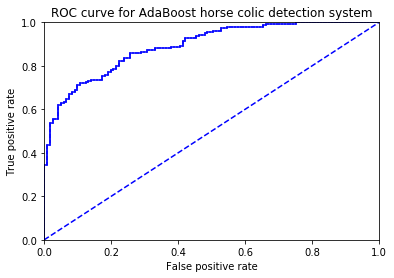

the Area Under the Curve is:  0.89181911041
67 13.0 0.194029850746


In [13]:
if __name__ == "__main__":
    # # 我们要将5个点进行分类
    # dataArr, labelArr = loadSimpData()
    # print 'dataArr', dataArr, 'labelArr', labelArr

    # # D表示最初值，对1进行均分为5份，平均每一个初始的概率都为0.2
    # # D的目的是为了计算错误概率： weightedError = D.T*errArr
    # D = mat(ones((5, 1))/5)
    # print 'D=', D.T

    # # bestStump, minError, bestClasEst = buildStump(dataArr, labelArr, D)
    # # print 'bestStump=', bestStump
    # # print 'minError=', minError
    # # print 'bestClasEst=', bestClasEst.T

    # # 分类器：weakClassArr
    # # 历史累计的分类结果集
    # weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 9)
    # print '\nweakClassArr=', weakClassArr, '\naggClassEst=', aggClassEst.T

    # """
    # 发现:
    # 分类的权重值：最大的值，为alpha的加和，最小值为-最大值
    # 特征的权重值：如果一个值误判的几率越小，那么D的特征权重越少
    # """

    # # 测试数据的分类结果, 观测：aggClassEst分类的最终权重
    # print adaClassify([0, 0], weakClassArr).T
    # print adaClassify([[5, 5], [0, 0]], weakClassArr).T

    # 马疝病数据集
    # 训练集合
    dataArr, labelArr = loadDataSet("7.AdaBoost/horseColicTraining2.txt")
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 40)
    print weakClassArr, '\n-----\n', aggClassEst.T
    # 计算ROC下面的AUC的面积大小
    plotROC(aggClassEst.T, labelArr)
    # 测试集合
    dataArrTest, labelArrTest = loadDataSet("7.AdaBoost/horseColicTest2.txt")
    m = shape(dataArrTest)[0]
    predicting10 = adaClassify(dataArrTest, weakClassArr)
    errArr = mat(ones((m, 1)))
    # 测试：计算总样本数，错误样本数，错误率
    print m, errArr[predicting10 != mat(labelArrTest).T].sum(), errArr[predicting10 != mat(labelArrTest).T].sum()/m